In [1]:
import os

import numpy as np
import pandas as pd
from scipy import interpolate
from scipy import spatial
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.utils.validation import check_array
from sklearn.utils.validation import check_is_fitted
from tqdm.auto import tqdm

from src import load_point_cloud
from src import show_point_cloud
from src import rms_angle_error
from src.utils import apply_weight

# Input data

In [2]:
xyz, n = load_point_cloud('Boxy_smooth100k_ddist_minmax_layers')

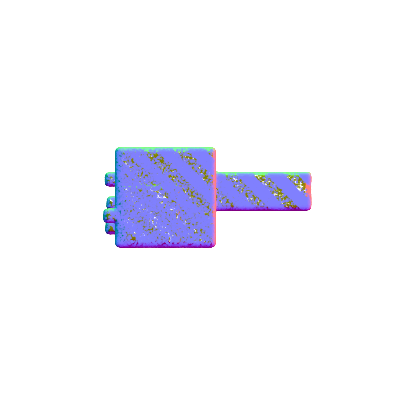

In [3]:
_, ax = show_point_cloud(xyz, n)

# Custom estimator

In [4]:
class NormalEstimator(BaseEstimator):
    """Surface normal estimator.

    Parameters
    ----------
    k : float, optional
        The number of nearest neighbors of a local neighborhood around
        a current query point. Default is 30
    deg : str, optional
        Degree of the bivariate spline. Default is 3
    s : float, optional
        Positive smoothing factor for the bivariate spline
    kernel : str, optional
        The weighting function. By default, all weights are set to 1
    gamma : float, optional
        A scaling factor for the weighting function. If not given, it
        is set to 1
    """
    def __init__(self, k=30, deg=3, s=None, kernel=None, gamma=None):
        self.k = k
        self.deg = deg
        self.s = s
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y=None):
        """A reference implementation of a fitting function.

        Parameters
        ----------
        X : numpy.ndarray
            The input point cloud of shape (n_points, 3)
        y : None
            Ignored

        Returns
        -------
        self : object
            Fitted normal estimator
        """
        X = check_array(X, accept_sparse=True)
        # create a kd-tree for quick nearest-neighbor lookup
        tree = spatial.KDTree(X)
        self.n_estim = np.empty_like(X)
        # iterate over all points
        for i, p in enumerate(X):
            # local neighbourhood
            _, idx = tree.query([p], k=self.k, workers=-1)
            nbhd = X[idx.flatten()]
            # change of basis
            nbhd_c = nbhd - nbhd.mean(axis=0)
            C = (nbhd_c.T @ nbhd_c) / (nbhd.shape[0] - 1)
            U, _, _ = np.linalg.svd(C)
            nbhd_t = nbhd_c @ U
            # add weights
            if self.kernel:
                w = apply_weight(p, nbhd, self.kernel, self.gamma)
            else:
                w = np.ones((nbhd.shape[0], ))
            # interpolate
            h = interpolate.SmoothBivariateSpline(*nbhd_t.T,
                                                  w=w,
                                                  kx=self.deg,
                                                  ky=self.deg,
                                                  s=self.s)
            self.interpolant_ = h
            # compute normals as partial derivatives of the "height" function
            ni = np.array([-h(*nbhd_t[0, :2], dx=1).item(),
                           -h(*nbhd_t[0, :2], dy=1).item(),
                           1])
            # convert normal coordinates into the original coordinate frame
            ni = U @ ni
            # normalization
            self.n_estim[i, :] = ni / np.linalg.norm(ni)
        self.is_fitted_ = True
        return self

    def predict(self, X=None):
        """Return estimated normals.

        Parameters
        ----------
        X : None
            Ignored

        Returns
        -------
        y : numpy.ndarray
            Estimated surface normals of shape (n_points, 3)
        """
        check_is_fitted(self, 'is_fitted_')
        return self.n_estim

# Baseline

In [5]:
k = 30
s = k - np.sqrt(2 * k)
s

22.254033307585168

In [6]:
estimator = NormalEstimator(k=k, deg=3, s=s, kernel=None, gamma=None)

In [7]:
estimator = estimator.fit(xyz)

In [8]:
n_estim = estimator.predict(xyz)
angle_err = rms_angle_error(estimator.predict(xyz), n, orient=False)
print(f'Unoriented normal angle error = {angle_err:.4f}°')

Unoriented normal angle error = 2.5478°


# Hyperparameter tuning

Training set only (validation is not possible in this case).
Validation set will be omitted.

In [9]:
data_path = 'data'

In [10]:
with open(os.path.join(data_path, 'trainingset_no_noise.txt')) as f:
    trainingset_no_noise = [line.strip() for line in f]
with open(os.path.join(data_path, 'trainingset_vardensity_whitenoise.txt')) as f:
    trainingset_vardensity_whitenoise = [line.strip() for line in f]
with open(os.path.join(data_path, 'trainingset_vardensity.txt')) as f:
    trainingset_vardensity = [line.strip() for line in f]
with open(os.path.join(data_path, 'trainingset_whitenoise.txt')) as f:
    trainingset_whitenoise = [line.strip() for line in f]

In [11]:
trainingset_all = (trainingset_no_noise
                   + trainingset_vardensity_whitenoise
                   + trainingset_vardensity
                   + trainingset_whitenoise)

In [12]:
X_train_d = {}
y_train_d = {}
for trainingset in set(trainingset_all):
    xyz, n = load_point_cloud(trainingset)
    X_train_d[trainingset] = xyz
    y_train_d[trainingset] = n

In [13]:
param_grid = [{'k': [10, 30],
               'deg': [2, 3],
               's': [None],
               'kernel': [None]},
              {'k': [30, 50, 100],
               's': [None], 
               'kernel': ['gaussian', 'inverse_multiquadric'],
               'gamma': [0.1, 0.3, 1]},
              {'k': [30, 50, 100],
               's': [None, 10, 0], 
               'kernel': ['rbf'],
               'gamma': [1, 3, 10]}]

In [14]:
scorer = lambda y, y_pred: rms_angle_error(y_pred, y, orient=False)
custom_scorer = make_scorer(scorer, greater_is_better=False)

In [28]:
df_grid_res = pd.DataFrame()

In [30]:
for key in tqdm(X_train_d.keys()):
    grid = GridSearchCV(estimator=NormalEstimator(),
                        param_grid=param_grid,
                        scoring=custom_scorer,
                        n_jobs=-1,
                        cv=[(slice(None), slice(None))],
                        verbose=2)
    grid.fit(X_train_d[key], y_train_d[key])
    df_temp = pd.DataFrame(grid.cv_results_)
    df_temp['dataset'] = key
    df_grid_res = pd.concat((df_grid_res, df_temp), ignore_index=True)

  0%|          | 0/48 [00:00<?, ?it/s]

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/s

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/s

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=850
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=850
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/s

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/s

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/s

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
No more knots can be added because the additional knot would (quasi)
coincide with an old one: s too small or too large a we

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

[CV] END ...................deg=3, k=30, kernel=None, s=None; total time=  37.0s
[CV] END gamma=0.3, k=30, kernel=inverse_multiquadric, s=None; total time=  40.0s
[CV] END .............gamma=1, k=50, kernel=gaussian, s=None; total time=  43.3s
[CV] END ....................gamma=1, k=50, kernel=rbf, s=10; total time=  43.8s
[CV] END ..................gamma=3, k=50, kernel=rbf, s=None; total time=  42.6s
[CV] END ...................gamma=10, k=30, kernel=rbf, s=10; total time=  38.5s
[CV] END ..................gamma=10, k=100, kernel=rbf, s=10; total time=  51.4s
[CV] END ...................deg=3, k=30, kernel=None, s=None; total time=  38.7s
[CV] END gamma=0.3, k=30, kernel=inverse_multiquadric, s=None; total time=  41.4s
[CV] END .............gamma=1, k=50, kernel=gaussian, s=None; total time=  42.2s
[CV] END .gamma=1, k=50, kernel=inverse_multiquadric, s=None; total time=  43.8s
[CV] END ....................gamma=1, k=100, kernel=rbf, s=0; total time= 2.8min
[CV] END .................

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=850
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1117
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=619
  warning

[CV] END ...................deg=2, k=10, kernel=None, s=None; total time=  32.2s
[CV] END gamma=0.1, k=100, kernel=inverse_multiquadric, s=None; total time=  54.6s
[CV] END gamma=1, k=100, kernel=inverse_multiquadric, s=None; total time=  55.1s
[CV] END ....................gamma=3, k=30, kernel=rbf, s=10; total time=  38.8s
[CV] END .....................gamma=3, k=50, kernel=rbf, s=0; total time= 1.0min
[CV] END ................gamma=10, k=100, kernel=rbf, s=None; total time=  45.7s
[CV] END ...................deg=3, k=10, kernel=None, s=None; total time=   0.0s
[CV] END ..........gamma=0.1, k=100, kernel=gaussian, s=None; total time= 2.9min
[CV] END ....................gamma=3, k=30, kernel=rbf, s=10; total time=  41.8s
[CV] END .....................gamma=3, k=30, kernel=rbf, s=0; total time=  40.0s
[CV] END ....................gamma=10, k=30, kernel=rbf, s=0; total time=  38.2s
[CV] END .................gamma=10, k=50, kernel=rbf, s=None; total time=  48.7s
[CV] END .................

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
the maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached:
s too small.
Weighted sum of squared residuals does not satisfy abs(fp-s)/s < tol.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small or
badly chosen eps.
Weighted sum of squared residuals does not satisfy abs(fp-s)/s < tol.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=571
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=519
  warnings.warn(message)
/home/alk/minicond

Fitting 1 folds for each of 49 candidates, totalling 49 fits
[CV] END ...................deg=3, k=10, kernel=None, s=None; total time=   0.0s
[CV] END ..........gamma=0.1, k=100, kernel=gaussian, s=None; total time=  51.7s
[CV] END .............gamma=1, k=30, kernel=gaussian, s=None; total time=  39.4s
[CV] END ..................gamma=1, k=30, kernel=rbf, s=None; total time=  40.0s
[CV] END .................gamma=1, k=100, kernel=rbf, s=None; total time=  53.4s
[CV] END .................gamma=3, k=100, kernel=rbf, s=None; total time=  54.8s
[CV] END ...................gamma=10, k=50, kernel=rbf, s=10; total time=  42.5s
[CV] END ...................deg=2, k=30, kernel=None, s=None; total time=  35.0s
[CV] END ...........gamma=0.3, k=30, kernel=gaussian, s=None; total time=  38.8s
[CV] END .............gamma=1, k=30, kernel=gaussian, s=None; total time=  38.8s
[CV] END .gamma=1, k=30, kernel=inverse_multiquadric, s=None; total time=  39.8s
[CV] END ....................gamma=1, k=50, kern

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=850
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419

[CV] END gamma=0.1, k=50, kernel=inverse_multiquadric, s=None; total time=  42.8s
[CV] END gamma=0.3, k=100, kernel=inverse_multiquadric, s=None; total time=  54.7s
[CV] END .....................gamma=1, k=30, kernel=rbf, s=0; total time=  41.4s
[CV] END ..................gamma=3, k=30, kernel=rbf, s=None; total time=  40.7s
[CV] END ....................gamma=3, k=50, kernel=rbf, s=10; total time=  43.2s
[CV] END ....................gamma=10, k=30, kernel=rbf, s=0; total time=  39.5s
[CV] END ...................gamma=10, k=100, kernel=rbf, s=0; total time= 1.4min
[CV] END gamma=0.1, k=50, kernel=inverse_multiquadric, s=None; total time=  59.3s
[CV] END gamma=0.3, k=100, kernel=inverse_multiquadric, s=None; total time= 2.3min
[CV] END ...................gamma=3, k=100, kernel=rbf, s=10; total time= 2.5min
[CV] END ....................gamma=3, k=100, kernel=rbf, s=0; total time= 1.4min
[CV] END ...........gamma=0.1, k=50, kernel=gaussian, s=None; total time=  42.8s
[CV] END ..........gam

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
No more knots can be added because the additional knot would (quasi)
coincide with an old one: s too small or too large a weight to an
inaccurate data point.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=519
  warnings.warn(message)


[CV] END ...................deg=2, k=30, kernel=None, s=None; total time=  34.8s
[CV] END ...........gamma=0.3, k=30, kernel=gaussian, s=None; total time=  39.6s
[CV] END .gamma=1, k=30, kernel=inverse_multiquadric, s=None; total time=  40.6s
[CV] END ..................gamma=1, k=50, kernel=rbf, s=None; total time=  43.6s
[CV] END .....................gamma=3, k=30, kernel=rbf, s=0; total time=  38.3s
[CV] END .................gamma=10, k=30, kernel=rbf, s=None; total time=  36.5s
[CV] END .................gamma=10, k=50, kernel=rbf, s=None; total time=  42.6s
[CV] END ...................deg=2, k=10, kernel=None, s=None; total time=  32.6s
[CV] END gamma=0.1, k=100, kernel=inverse_multiquadric, s=None; total time= 2.9min
[CV] END .................gamma=10, k=30, kernel=rbf, s=None; total time=  38.2s
[CV] END ...................gamma=10, k=30, kernel=rbf, s=10; total time=  39.3s
[CV] END ...................gamma=10, k=100, kernel=rbf, s=0; total time= 2.0min
[CV] END gamma=0.1, k=30, 

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)


[CV] END ...........gamma=0.1, k=50, kernel=gaussian, s=None; total time=  42.5s
[CV] END ..........gamma=0.3, k=100, kernel=gaussian, s=None; total time=  54.2s
[CV] END ....................gamma=1, k=30, kernel=rbf, s=10; total time=  40.2s
[CV] END ...................gamma=1, k=100, kernel=rbf, s=10; total time=  53.5s
[CV] END ....................gamma=3, k=100, kernel=rbf, s=0; total time= 2.2min
[CV] END ...........gamma=0.1, k=50, kernel=gaussian, s=None; total time=  55.7s
[CV] END ..........gamma=0.3, k=100, kernel=gaussian, s=None; total time=  52.8s
[CV] END .....................gamma=1, k=30, kernel=rbf, s=0; total time=  41.7s
[CV] END ..................gamma=1, k=50, kernel=rbf, s=None; total time=  42.1s
[CV] END .....................gamma=3, k=50, kernel=rbf, s=0; total time= 1.0min
[CV] END .................gamma=3, k=100, kernel=rbf, s=None; total time=  52.7s
[CV] END ...................deg=2, k=30, kernel=None, s=None; total time=  34.3s
[CV] END ...........gamma=0.

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=519
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=850
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=619
  warnings

Fitting 1 folds for each of 49 candidates, totalling 49 fits
[CV] END ...........gamma=0.1, k=30, kernel=gaussian, s=None; total time=  37.9s
[CV] END ...........gamma=0.3, k=50, kernel=gaussian, s=None; total time=  42.9s
[CV] END .gamma=1, k=50, kernel=inverse_multiquadric, s=None; total time=  44.9s
[CV] END .....................gamma=1, k=50, kernel=rbf, s=0; total time= 1.0min
[CV] END ...................gamma=3, k=100, kernel=rbf, s=10; total time=  53.4s
[CV] END ....................gamma=10, k=50, kernel=rbf, s=0; total time=  56.5s
[CV] END ...........gamma=0.1, k=30, kernel=gaussian, s=None; total time=  38.8s
[CV] END ...........gamma=0.3, k=50, kernel=gaussian, s=None; total time=  42.7s
[CV] END ............gamma=1, k=100, kernel=gaussian, s=None; total time=  53.3s
[CV] END gamma=1, k=100, kernel=inverse_multiquadric, s=None; total time=  55.9s
[CV] END ..................gamma=3, k=50, kernel=rbf, s=None; total time=  44.6s
[CV] END ....................gamma=3, k=50, kern

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
No more knots can be added because the additional knot would (quasi)
coincide with an old one: s too small or too large a weight to an
inaccurate data point.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/s

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=850
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=619
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=850
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

[CV] END gamma=0.1, k=30, kernel=inverse_multiquadric, s=None; total time=  40.3s
[CV] END gamma=0.3, k=50, kernel=inverse_multiquadric, s=None; total time=  43.9s
[CV] END .....................gamma=1, k=30, kernel=rbf, s=0; total time=  40.5s
[CV] END ..................gamma=1, k=50, kernel=rbf, s=None; total time=  41.8s
[CV] END ...................gamma=3, k=100, kernel=rbf, s=10; total time=  52.0s
[CV] END ....................gamma=3, k=100, kernel=rbf, s=0; total time= 1.9min
[CV] END ...........gamma=0.1, k=50, kernel=gaussian, s=None; total time=  43.6s
[CV] END ..........gamma=0.3, k=100, kernel=gaussian, s=None; total time=  53.7s
[CV] END .................gamma=1, k=100, kernel=rbf, s=None; total time=  54.1s
[CV] END ...................gamma=1, k=100, kernel=rbf, s=10; total time=  52.8s
[CV] END ...................gamma=10, k=50, kernel=rbf, s=10; total time=  44.5s
[CV] END ....................gamma=10, k=50, kernel=rbf, s=0; total time=  44.6s
[CV] END .................

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
No more knots can be added because the additional knot would (quasi)
coincide with an old one: s too small or too large a weight to an
inaccurate data point.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)


[CV] END ...................gamma=10, k=30, kernel=rbf, s=10; total time=  38.0s
[CV] END ...................deg=2, k=30, kernel=None, s=None; total time=  34.9s
[CV] END ...........gamma=0.3, k=30, kernel=gaussian, s=None; total time=  39.3s
[CV] END .............gamma=1, k=50, kernel=gaussian, s=None; total time=  44.0s
[CV] END .gamma=1, k=50, kernel=inverse_multiquadric, s=None; total time=  44.7s
[CV] END .....................gamma=3, k=50, kernel=rbf, s=0; total time= 1.0min
[CV] END .................gamma=3, k=100, kernel=rbf, s=None; total time=  49.4s
[CV] END ...................deg=3, k=10, kernel=None, s=None; total time=   0.0s
[CV] END ..........gamma=0.1, k=100, kernel=gaussian, s=None; total time=  54.3s
[CV] END .............gamma=1, k=30, kernel=gaussian, s=None; total time=  38.7s
[CV] END .gamma=1, k=30, kernel=inverse_multiquadric, s=None; total time=  38.7s
[CV] END ....................gamma=3, k=30, kernel=rbf, s=10; total time=  39.1s
[CV] END ...................

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
No more knots can be added because the additional knot would (quasi)
coincide with an old one: s too small or too large a weight to an
inaccurate data point.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/

Fitting 1 folds for each of 49 candidates, totalling 49 fits
[CV] END ...................gamma=1, k=100, kernel=rbf, s=10; total time=  52.5s
[CV] END ...................gamma=10, k=50, kernel=rbf, s=10; total time=  43.6s
[CV] END ....................gamma=10, k=50, kernel=rbf, s=0; total time=  33.9s
[CV] END ...........gamma=0.1, k=30, kernel=gaussian, s=None; total time=  38.7s
[CV] END ...........gamma=0.3, k=50, kernel=gaussian, s=None; total time=  43.9s
[CV] END ..................gamma=1, k=30, kernel=rbf, s=None; total time=  36.9s
[CV] END ....................gamma=1, k=30, kernel=rbf, s=10; total time=  38.9s
[CV] END ..................gamma=3, k=50, kernel=rbf, s=None; total time=  42.3s
[CV] END ....................gamma=3, k=50, kernel=rbf, s=10; total time=  44.7s
[CV] END ...................gamma=10, k=100, kernel=rbf, s=0; total time= 1.6min
[CV] END gamma=0.1, k=50, kernel=inverse_multiquadric, s=None; total time=  44.6s
[CV] END gamma=0.3, k=100, kernel=inverse_multi

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits
[CV] END ...................deg=2, k=10, kernel=None, s=None; total time=  32.3s
[CV] END gamma=0.1, k=100, kernel=inverse_multiquadric, s=None; total time=  55.7s
[CV] END ....................gamma=1, k=50, kernel=rbf, s=10; total time=  44.6s
[CV] END .....................gamma=1, k=50, kernel=rbf, s=0; total time= 1.0min
[CV] END ....................gamma=10, k=30, kernel=rbf, s=0; total time=  38.7s
[CV] END .................gamma=10, k=50, kernel=rbf, s=None; total time=  41.1s
[CV] END ...................deg=3, k=10, kernel=None, s=None; total time=   0.0s
[CV] END ..........gamma=0.1, k=100, kernel=gaussian, s=None; total time=  53.3s
[CV] END .............gamma=1, k=30, kernel=gaussian, s=None; total time=  39.6s
[CV] END .gamma=1, k=30, kernel=inverse_multiquadric, s=None; total time=  39.3s
[CV] END ....................gamma=3, k=30, kernel=rbf, s=10; total time=  38.2s
[CV] END .....................gamma=3, k=30, k

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)


[CV] END ....................gamma=3, k=30, kernel=rbf, s=10; total time=  39.6s
[CV] END .....................gamma=3, k=30, kernel=rbf, s=0; total time=  40.6s
[CV] END ................gamma=10, k=100, kernel=rbf, s=None; total time=  52.8s
[CV] END ..................gamma=10, k=100, kernel=rbf, s=10; total time=  41.3s
[CV] END gamma=0.1, k=30, kernel=inverse_multiquadric, s=None; total time=  40.6s
[CV] END gamma=0.3, k=50, kernel=inverse_multiquadric, s=None; total time=  44.1s
[CV] END .....................gamma=1, k=30, kernel=rbf, s=0; total time=  39.2s
[CV] END ..................gamma=1, k=50, kernel=rbf, s=None; total time=  44.0s
[CV] END ...................gamma=3, k=100, kernel=rbf, s=10; total time= 1.2min
[CV] END ....................gamma=3, k=100, kernel=rbf, s=0; total time= 1.9min
[CV] END ...........gamma=0.1, k=50, kernel=gaussian, s=None; total time=  44.3s
[CV] END gamma=0.3, k=100, kernel=inverse_multiquadric, s=None; total time=  54.6s
[CV] END ...............

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=850
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=719
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required stor

[CV] END ...................deg=3, k=30, kernel=None, s=None; total time=  37.0s
[CV] END gamma=0.3, k=30, kernel=inverse_multiquadric, s=None; total time=  39.6s
[CV] END ............gamma=1, k=100, kernel=gaussian, s=None; total time=  53.9s
[CV] END gamma=1, k=100, kernel=inverse_multiquadric, s=None; total time=  55.4s
[CV] END .................gamma=10, k=30, kernel=rbf, s=None; total time=  39.4s
[CV] END ...................gamma=10, k=30, kernel=rbf, s=10; total time=  39.0s
[CV] END ...................deg=2, k=10, kernel=None, s=None; total time=  31.7s
[CV] END gamma=0.1, k=100, kernel=inverse_multiquadric, s=None; total time=  54.1s
[CV] END ....................gamma=1, k=50, kernel=rbf, s=10; total time=  44.0s
[CV] END .....................gamma=1, k=50, kernel=rbf, s=0; total time= 1.0min
[CV] END ....................gamma=10, k=30, kernel=rbf, s=0; total time=  40.7s
[CV] END .................gamma=10, k=50, kernel=rbf, s=None; total time=  41.7s
[CV] END ................

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)


[CV] END ...................gamma=10, k=50, kernel=rbf, s=10; total time=  42.0s
[CV] END ....................gamma=10, k=50, kernel=rbf, s=0; total time=  53.1s
[CV] END ...........gamma=0.1, k=30, kernel=gaussian, s=None; total time=  39.2s
[CV] END ...........gamma=0.3, k=50, kernel=gaussian, s=None; total time=  43.2s
[CV] END ..................gamma=1, k=30, kernel=rbf, s=None; total time=  39.6s
[CV] END ....................gamma=1, k=30, kernel=rbf, s=10; total time=  40.9s
[CV] END .....................gamma=3, k=50, kernel=rbf, s=0; total time=  59.1s
[CV] END .................gamma=3, k=100, kernel=rbf, s=None; total time=  50.2s
[CV] END ...................deg=2, k=30, kernel=None, s=None; total time=  34.6s
[CV] END ...........gamma=0.3, k=30, kernel=gaussian, s=None; total time=  38.9s
[CV] END .............gamma=1, k=50, kernel=gaussian, s=None; total time=  44.2s
[CV] END .gamma=1, k=50, kernel=inverse_multiquadric, s=None; total time=  42.1s
[CV] END ..................g

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=850
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=719
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required stor

[CV] END .....................gamma=1, k=50, kernel=rbf, s=0; total time= 1.0min
[CV] END ....................gamma=10, k=30, kernel=rbf, s=0; total time=  39.8s
[CV] END .................gamma=10, k=50, kernel=rbf, s=None; total time=  40.3s
[CV] END ...................deg=2, k=30, kernel=None, s=None; total time=  35.4s
[CV] END ...........gamma=0.3, k=30, kernel=gaussian, s=None; total time=  39.6s
[CV] END .............gamma=1, k=50, kernel=gaussian, s=None; total time=  42.2s
[CV] END .gamma=1, k=50, kernel=inverse_multiquadric, s=None; total time=  42.8s
[CV] END ..................gamma=3, k=50, kernel=rbf, s=None; total time=  43.8s
[CV] END ....................gamma=3, k=50, kernel=rbf, s=10; total time=  44.4s
[CV] END ...................gamma=10, k=100, kernel=rbf, s=0; total time= 1.8min
[CV] END gamma=0.1, k=50, kernel=inverse_multiquadric, s=None; total time=  44.2s
[CV] END ..........gamma=0.3, k=100, kernel=gaussian, s=None; total time=  53.3s
[CV] END .................g

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1 fits failed out of a total of 49.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/tmp/ipykernel_21529/2011654019.py", line 61, in fit
  File "/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py", line 1395, in __init__
    x, y, z, w = self._validate_input(x, y, z, w, kx, ky, eps)
  File "/home/alk/miniconda3/envs/3d/li

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=719
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=850
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/s

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=988
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: ier=1299
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:141

Fitting 1 folds for each of 49 candidates, totalling 49 fits


/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)


[CV] END ....................gamma=1, k=50, kernel=rbf, s=10; total time=  44.3s
[CV] END .....................gamma=1, k=50, kernel=rbf, s=0; total time= 1.0min
[CV] END ....................gamma=10, k=30, kernel=rbf, s=0; total time=  39.7s
[CV] END .................gamma=10, k=50, kernel=rbf, s=None; total time=  42.8s
[CV] END ...................deg=3, k=10, kernel=None, s=None; total time=   0.0s
[CV] END ..........gamma=0.1, k=100, kernel=gaussian, s=None; total time=  54.2s
[CV] END .............gamma=1, k=30, kernel=gaussian, s=None; total time=  38.6s
[CV] END .gamma=1, k=30, kernel=inverse_multiquadric, s=None; total time=  38.6s
[CV] END ....................gamma=3, k=30, kernel=rbf, s=10; total time=  39.2s
[CV] END .....................gamma=3, k=30, kernel=rbf, s=0; total time=  40.9s
[CV] END ................gamma=10, k=100, kernel=rbf, s=None; total time=  53.5s
[CV] END ..................gamma=10, k=100, kernel=rbf, s=10; total time=  33.2s
[CV] END gamma=0.1, k=30, ke

/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/alk/miniconda3/envs/3d/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
No more knots can be added because the additional knot would (quasi)
coincide with an old one: s too small or too large a weight to an
inaccurate data point.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
/home/

In [37]:
df_grid_res.to_csv('grid_res.csv')

In [38]:
df_grid_res.set_index(
    df_grid_res['params'].apply(
        lambda x: '_'.join(str(val) for val in x.values())
    )
).rename_axis('kernel')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_deg,param_k,param_kernel,param_s,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,dataset
kernel,,,,,,,,,,,,,,,
2_10_None_None,32.197387,0.0,0.008310,0.0,2,10,None,None,NaN,"{'deg': 2, 'k': 10, 'kernel': None, 's': None}",-39.131370,-39.131370,0.0,48,tortuga100k_noise_white_1.00e-02
2_30_None_None,34.753637,0.0,0.009091,0.0,2,30,None,None,NaN,"{'deg': 2, 'k': 30, 'kernel': None, 's': None}",-9.294505,-9.294505,0.0,13,tortuga100k_noise_white_1.00e-02
3_10_None_None,0.042819,0.0,0.000000,0.0,3,10,None,None,NaN,"{'deg': 3, 'k': 10, 'kernel': None, 's': None}",NaN,NaN,NaN,49,tortuga100k_noise_white_1.00e-02
3_30_None_None,36.944293,0.0,0.008454,0.0,3,30,None,None,NaN,"{'deg': 3, 'k': 30, 'kernel': None, 's': None}",-17.470812,-17.470812,0.0,47,tortuga100k_noise_white_1.00e-02
0.1_30_gaussian_None,37.881319,0.0,0.008564,0.0,NaN,30,gaussian,None,0.1,"{'gamma': 0.1, 'k': 30, 'kernel': 'gaussian', ...",-17.470810,-17.470810,0.0,42,tortuga100k_noise_white_1.00e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10_50_rbf_10,56.371130,0.0,0.006657,0.0,NaN,50,rbf,10,10,"{'gamma': 10, 'k': 50, 'kernel': 'rbf', 's': 10}",-28.521380,-28.521380,0.0,21,dragon_xyzrgb100k_noise_white_1.00e-02
10_50_rbf_0,51.695438,0.0,0.004900,0.0,NaN,50,rbf,0,10,"{'gamma': 10, 'k': 50, 'kernel': 'rbf', 's': 0}",-31.232078,-31.232078,0.0,23,dragon_xyzrgb100k_noise_white_1.00e-02
10_100_rbf_None,55.173666,0.0,0.007483,0.0,NaN,100,rbf,None,10,"{'gamma': 10, 'k': 100, 'kernel': 'rbf', 's': ...",-22.712571,-22.712571,0.0,6,dragon_xyzrgb100k_noise_white_1.00e-02
